# Project 3 part 2b

## *Important Note*: In this notebook we will work with all the possible text extracted from each posts ( titles + text; even if they don't have any text).

# The problem:
**The saying goes like this: "(There's) no such thing as a stupid question (only a stupid answer)"** 

The Boston Institute of Linguistics (BIL) wants to obtain hard evidence on the extent to which this saying is true. While the underlying goal of this saying is to support the quest for knowledge (by getting rid of the fear to look 'not-smart' for asking questions), the BIL believes that there might be some linguistic truth in this saying. 

They want us to analyze whether there is much difference between the questions that obtain serious responses, and those that obtain 'bad-responses'. 


The BIL has asked us to look for 'subreddits' where the answers given to potentially normal questions are bad responses, and to compare them to the questions from another subreddit where the questions receive good/normal responses.


<details><summary>Theory behind it</summary>

> $H_0:$ There are good and bad questions. Good questions tend to receive good answers and bad questions tend to receive bad answers.

> $H_A:$ Questions can be relatively similar , yet are still able to receive both good and bad answers.

- If there is a big difference between the two, then it not disprove the null-hypothesis, since it might be that bad questions DO lead to bad responses. 
- On the other hand, if the questions are difficult to differentiate (questions that receive bad responses are similar to questions that receive good responses), then we prove the alternative hypothesis that 'there is not such a thing as a stupid question, only stupid answers'. 
</details>

For this task we have chosen the subreddits of r/Advice and r/shittyadvice. In the former, the questions receive normal reponses, while in the later, the questions receive bad responses.
We will contribute to BIL's study by responding the following questions:
    - To what extent can we differentiate whether a post is from the r/Advice subreddit or from the r/shittysubreddit, by only looking at the post titles? 
    - How can we improve our predictions?

For this project, the goal is two-fold:
1. Using Reddit's API, we'll collect posts from the two aforementioned subreddits.
2. We'll then use NLP to train a classifier on which subreddit a given post came from. This is a binary classification problem.

**In this Jupyter Notebook, we will focus on the *second* part of the project.**

In [7]:
import pandas as pd
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

## Read the data:
First we need to read the dataframe we created in the part 1 of the project

In [8]:
data = pd.read_csv('../data (gathered)/project3.csv', encoding = 'ISO-8859-1')

In [9]:
# We take a look at the 'head' and 'tail' of the dataframe to see what is made of.
data.head()

,Unnamed: 0,titles,text,subreddit type
0,5097,"Hey it's 9/11, so what kinds of sales and door...",NaN,0
1,5310,I think the ghost haunting my house is into me...,NaN,0
2,957,I have feelings for someone I met online. I do...,"I haven't had feelings for anyone in years, le...",1
3,306,Is this kids hair color black or brown?,"Tell me reddit, black or brown?\n\nhttps://med...",1
4,5088,Im gonna keep this post simple,"Alright guys, how would one go about getting f...",0


In [10]:
data.tail()

,Unnamed: 0,titles,text,subreddit type
1944,529,Does my Username sound like follow the christi...,NaN,1
1945,5950,Swiped right on my cousin who is married.,"Was drunk and she's hot, think I have a chance?",0
1946,297,Any advice on tickling myself in my sleep ?,Iâve been told and do have videos of my tick...,1
1947,726,Wife (34f) whose husband (35m) told her she is...,My husband and I have been married for 11 year...,1
1948,692,Is it weird that I dry and not wash my clothes?,"So I usually do all my laundry every weekend, ...",1


In [11]:
# We also check (again) that we have sufficient data from both of the subreddits.
data['subreddit type'].value_counts()

0    991
1    958
Name: subreddit type, dtype: int64

**Comment:** we can see that we do not have unbalanced data, which is a good thing.

In [12]:
# Looking at the data shape we notice that we have one more column than we had in part 1 (the previous Jupyter notebook)
data.shape

(1949, 4)

### Dropping missing values
We look at the missing values we have and decide whether to drop them or not.

In [13]:
data.isnull().sum()

Unnamed: 0          0
titles              0
text              715
subreddit type      0
dtype: int64

**Comment:** We notice that there are 715 rows that are missing the text.
Dropping them would mean loosing almost half of our data. Moreover, the missing text comes mostly from the second subreddit (shittyadvice). Dropping all the text values would make our model unbalanced. 
Since we are focusing on the titles for our X values, we decide to not drop the rows.

In [14]:
# First, we created a model without the rows that had missing values, but this model was worse than the others.
#data.dropna(inplace=True)

### Dropping unnecessary columns:
We proceed to drop the unnecessary columns (e.g. 'Unnamed: 0')

In [15]:
data.drop('Unnamed: 0', axis=1, inplace=True)

In [16]:
data.head()

,titles,text,subreddit type
0,"Hey it's 9/11, so what kinds of sales and door...",NaN,0
1,I think the ghost haunting my house is into me...,NaN,0
2,I have feelings for someone I met online. I do...,"I haven't had feelings for anyone in years, le...",1
3,Is this kids hair color black or brown?,"Tell me reddit, black or brown?\n\nhttps://med...",1
4,Im gonna keep this post simple,"Alright guys, how would one go about getting f...",0


In [17]:
# We check to see whether the shape is the same as in part 1 of the project (1949,3)
data.shape

(1949, 3)

# Creating a new column with ALL the text (titles + text)

In [18]:
data['all_text']= data['titles'] + ' ' + data['text'].map(str)

In [19]:
data

,titles,text,subreddit type,all_text
0,"Hey it's 9/11, so what kinds of sales and door...",NaN,0,"Hey it's 9/11, so what kinds of sales and door..."
1,I think the ghost haunting my house is into me...,NaN,0,I think the ghost haunting my house is into me...
2,I have feelings for someone I met online. I do...,"I haven't had feelings for anyone in years, le...",1,I have feelings for someone I met online. I do...
3,Is this kids hair color black or brown?,"Tell me reddit, black or brown?\n\nhttps://med...",1,Is this kids hair color black or brown? Tell m...
4,Im gonna keep this post simple,"Alright guys, how would one go about getting f...",0,"Im gonna keep this post simple Alright guys, h..."
...,...,...,...,...
1944,Does my Username sound like follow the christi...,NaN,1,Does my Username sound like follow the christi...
1945,Swiped right on my cousin who is married.,"Was drunk and she's hot, think I have a chance?",0,Swiped right on my cousin who is married. Was ...
1946,Any advice on tickling myself in my sleep ?,Iâve been told and do have videos of my tick...,1,Any advice on tickling myself in my sleep ? Iâ...
1947,Wife (34f) whose husband (35m) told her she is...,My husband and I have been married for 11 year...,1,Wife (34f) whose husband (35m) told her she is...


In [20]:
data['all_text'].head()

0    Hey it's 9/11, so what kinds of sales and door...
1    I think the ghost haunting my house is into me...
2    I have feelings for someone I met online. I do...
3    Is this kids hair color black or brown? Tell m...
4    Im gonna keep this post simple Alright guys, h...
Name: all_text, dtype: object

In [21]:
data.dtypes

titles            object
text              object
subreddit type     int64
all_text          object
dtype: object

In [22]:
data.isnull().sum()

titles              0
text              715
subreddit type      0
all_text            0
dtype: int64

# EDA
We proceed to the EDA

- We will be taking the 'titles' as our X variable (since it has no missing values.
- We will be using the 'subreddit type' column as our y variable. 

In [23]:
X = data['all_text']
y = data['subreddit type']

In [24]:
y.value_counts()

0    991
1    958
Name: subreddit type, dtype: int64

In [25]:
y.value_counts(normalize=True)

0    0.508466
1    0.491534
Name: subreddit type, dtype: float64

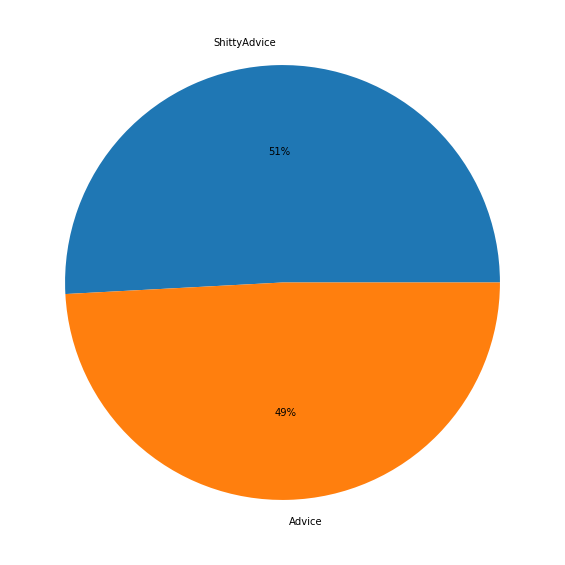

In [26]:
plt.figure(figsize=(25, 10))
labels=['ShittyAdvice', 'Advice']
plt.pie(y.value_counts(normalize=True), labels=labels,  autopct='%1.0f%%');

In [27]:
y.shape

(1949,)

We look at the distribution of lenght of titles to see how long are they on average and whether there is a skew.

In [28]:
len_status = [len(s) for s in X]

In [29]:
import matplotlib.pyplot as plt

(array([1675.,  187.,   54.,    9.,    9.,    3.,    3.,    4.,    3.,
           2.]),
 array([   15. ,  1343.5,  2672. ,  4000.5,  5329. ,  6657.5,  7986. ,
         9314.5, 10643. , 11971.5, 13300. ]),
 <a list of 10 Patch objects>)

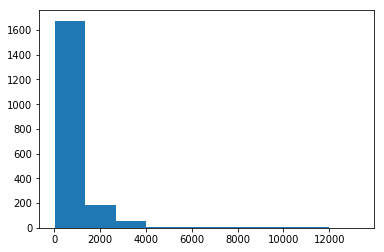

In [30]:
plt.hist(len_status)

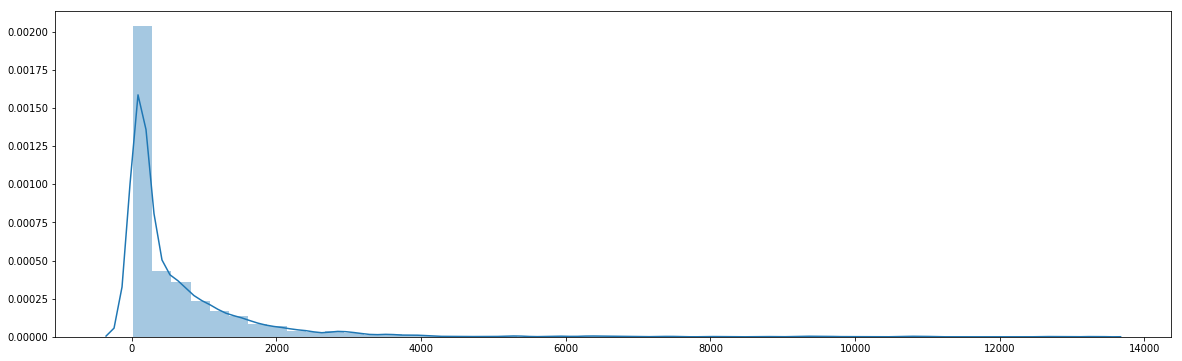

In [31]:
plt.figure(figsize=(20, 6))
sns.distplot(len_status)

(array([1.466e+03, 2.820e+02, 9.900e+01, 5.000e+01, 2.100e+01, 3.000e+00,
        6.000e+00, 5.000e+00, 3.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
        3.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([3.00000e+00, 1.58020e+02, 3.13040e+02, 4.68060e+02, 6.23080e+02,
        7.78100e+02, 9.33120e+02, 1.08814e+03, 1.24316e+03, 1.39818e+03,
        1.55320e+03, 1.70822e+03, 1.86324e+03, 2.01826e+03, 2.17328e+03,
        2.32830e+03, 2.48332e+03, 2.63834e+03, 2.79336e+03, 2.94838e+03,
        3.10340e+03, 3.25842e+03, 3.41344e+03, 3.56846e+03, 3.72348e+03,
        3.8

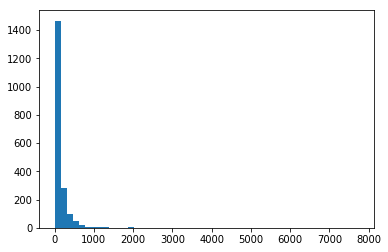

In [32]:
num_words= [len(s.split(' ')) for s in X]
plt.hist(num_words, bins=50)

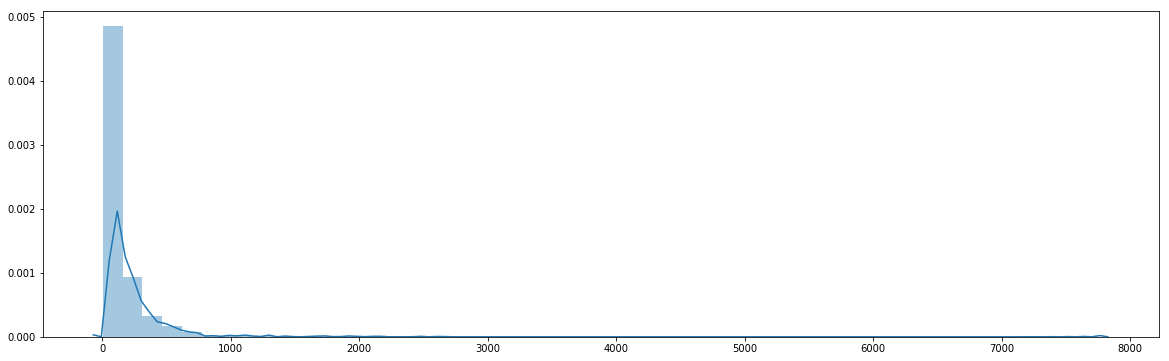

In [33]:
plt.figure(figsize=(20, 6))
sns.distplot(num_words)

There seems to be a bit of a right skew.
- In other words, some titles are very long.
    - The explanation for this is that some titles explain the whole situation, while others use the text to explain the situation.

# Cvec and Tvec Log vs Cvec and Tvec Bernoulli

In [34]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Base values (to check whether our models improve them)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [36]:
y_train.value_counts(normalize=True)

0    0.508812
1    0.491188
Name: subreddit type, dtype: float64

In [37]:
y_test.value_counts(normalize=True)

0    0.507764
1    0.492236
Name: subreddit type, dtype: float64

In [38]:
train_base = 0.490847
test_base = 0.491879

## Fitting Cvec

In [39]:
cvec = CountVectorizer(stop_words='english')

In [40]:
X_train_cvec = cvec.fit_transform(X_train)

In [41]:
X_test_cvec = cvec.transform(X_test)

In [42]:
y_test.value_counts(normalize=True) 

0    0.507764
1    0.492236
Name: subreddit type, dtype: float64

In [43]:
# Instantiate logistic regression.
lr = LogisticRegression()

# Fit logistic regression.
lr.fit(X_train_cvec, y_train)

# Evaluate logistic regression.
print(f'Training Score: {lr.score(X_train_cvec, y_train)}')
print(f'Testing Score: {lr.score(X_test_cvec, y_test)}')

Training Score: 0.9877394636015325
Testing Score: 0.8835403726708074


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [44]:
cvec_train_score = lr.score(X_train_cvec, y_train)

In [45]:
cvec_test_score  = lr.score(X_test_cvec, y_test)

In [46]:
def get_top_n_words(corpus, n=None):

    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [47]:
aa = data['all_text'].loc[data['subreddit type']==1]

In [48]:
aa.shape

(958,)

In [49]:
bb = data['all_text'].loc[data['subreddit type']==0]

In [50]:
bb.shape

(991,)

In [51]:
get_top_n_words(aa, n=10)

[('just', 1275),
 ('like', 1208),
 ('iâ', 1079),
 ('know', 928),
 ('want', 793),
 ('really', 765),
 ('time', 732),
 ('ve', 662),
 ('feel', 587),
 ('friends', 565)]

In [52]:
get_top_n_words(bb, n=10)

[('nan', 666),
 ('just', 127),
 ('want', 109),
 ('help', 86),
 ('like', 81),
 ('don', 76),
 ('really', 76),
 ('need', 75),
 ('iâ', 74),
 ('know', 73)]

In [53]:
cvec.get_feature_names()

['00',
 '000',
 '00am',
 '00pm',
 '02',
 '04',
 '09',
 '0s',
 '0srs0hr9cmm',
 '10',
 '100',
 '1000',
 '100k',
 '101',
 '107f',
 '10hr',
 '10k',
 '10pm',
 '10th',
 '10x',
 '11',
 '110',
 '1106',
 '111613',
 '11pm',
 '11th',
 '11ï',
 '12',
 '120d',
 '12hr',
 '12k',
 '12th',
 '13',
 '13778680',
 '13k',
 '13th',
 '14',
 '14c',
 '14m',
 '14th',
 '15',
 '150',
 '153',
 '15m',
 '15pm',
 '16',
 '16f',
 '16m',
 '16th',
 '17',
 '17f',
 '17ishm',
 '17m',
 '17th',
 '18',
 '180',
 '18f',
 '18m',
 '18th',
 '19',
 '1950s',
 '1975',
 '1986',
 '1990',
 '1997',
 '19f',
 '1am',
 '1h',
 '1k',
 '1st',
 '20',
 '200',
 '2000',
 '2001',
 '2003',
 '2011',
 '2013',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2019th',
 '2020',
 '2021',
 '2022',
 '2077',
 '20f',
 '20k',
 '20m',
 '20s',
 '20th',
 '20yo',
 '21',
 '21f',
 '21m',
 '21st',
 '21stâ',
 '22',
 '22f',
 '22m',
 '22nd',
 '23',
 '23f',
 '23m',
 '24',
 '24f',
 '24m',
 '25',
 '250',
 '25th',
 '26',
 '26f',
 '26m',
 '26th',
 '27',
 '27f',
 '27m',
 '27th',
 '

# Naive Bayes - Bernoulli (cvec)

In [54]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()

clf.fit(X_train_cvec, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [55]:
clf.score(X_train_cvec, y_train)

0.8505747126436781

In [56]:
clf.score(X_test_cvec, y_test)

0.8354037267080745

In [57]:
bernoulli_train_score_cvec = clf.score(X_train_cvec, y_train)
bernoulli_test_score_cvec = clf.score(X_test_cvec, y_test)

# Fitting Tvec

In [58]:
tvec = TfidfVectorizer(stop_words='english')

In [59]:
X_train_tvec = tvec.fit_transform(X_train)

In [60]:
X_train_tvec.shape

(1305, 9042)

In [61]:
X_train_tvec.todense()[:5,:30]

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [62]:
tvec.get_feature_names()

['00',
 '000',
 '00am',
 '00pm',
 '02',
 '04',
 '09',
 '0s',
 '0srs0hr9cmm',
 '10',
 '100',
 '1000',
 '100k',
 '101',
 '107f',
 '10hr',
 '10k',
 '10pm',
 '10th',
 '10x',
 '11',
 '110',
 '1106',
 '111613',
 '11pm',
 '11th',
 '11ï',
 '12',
 '120d',
 '12hr',
 '12k',
 '12th',
 '13',
 '13778680',
 '13k',
 '13th',
 '14',
 '14c',
 '14m',
 '14th',
 '15',
 '150',
 '153',
 '15m',
 '15pm',
 '16',
 '16f',
 '16m',
 '16th',
 '17',
 '17f',
 '17ishm',
 '17m',
 '17th',
 '18',
 '180',
 '18f',
 '18m',
 '18th',
 '19',
 '1950s',
 '1975',
 '1986',
 '1990',
 '1997',
 '19f',
 '1am',
 '1h',
 '1k',
 '1st',
 '20',
 '200',
 '2000',
 '2001',
 '2003',
 '2011',
 '2013',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2019th',
 '2020',
 '2021',
 '2022',
 '2077',
 '20f',
 '20k',
 '20m',
 '20s',
 '20th',
 '20yo',
 '21',
 '21f',
 '21m',
 '21st',
 '21stâ',
 '22',
 '22f',
 '22m',
 '22nd',
 '23',
 '23f',
 '23m',
 '24',
 '24f',
 '24m',
 '25',
 '250',
 '25th',
 '26',
 '26f',
 '26m',
 '26th',
 '27',
 '27f',
 '27m',
 '27th',
 '

In [63]:
X_test_tvec = tvec.transform(X_test)

In [64]:
# Instantiate logistic regression.
lr = LogisticRegression()

# Fit logistic regression.
lr.fit(X_train_tvec, y_train)

# Evaluate logistic regression.
print(f'Training Score: {lr.score(X_train_tvec, y_train)}')
print(f'Testing Score: {lr.score(X_test_tvec, y_test)}')

Training Score: 0.9540229885057471
Testing Score: 0.8773291925465838


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [65]:
tvec_train_score = lr.score(X_train_tvec, y_train)

In [66]:
tvec_test_score = lr.score(X_test_tvec, y_test)

# Naive Bayes - Bernoulli (tvec)

In [67]:
clf = BernoulliNB()

clf.fit(X_train_tvec, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [68]:
clf.score(X_train_tvec, y_train)

0.8505747126436781

In [69]:
clf.score(X_test_tvec, y_test)

0.8354037267080745

In [70]:
bernoulli_train_score_tvec = clf.score(X_train_tvec, y_train)
bernoulli_test_score_tvec = clf.score(X_test_tvec, y_test)

# Gridsearching

## Cvec

In [71]:
import warnings

In [72]:
warnings.filterwarnings('ignore')

In [73]:
pipe = Pipeline([
    ('cvec', CountVectorizer(lowercase=False)),
    ('lr', LogisticRegression())
])

In [74]:
pipe_params = {'cvec__max_features': [100,500,1000],
               'cvec__min_df': [1],
               'cvec__max_df':[.50],
               'cvec__stop_words':['english'],
               'cvec__ngram_range': [(1,1), (1,2)]}

In [75]:
gs = GridSearchCV(pipe, # what object are we optimizing?
                  pipe_params, # what parameters values are we searching?
                  cv=3) # 3-fold cross-validation.

In [76]:
gs.fit(X_train, y_train);

In [77]:
print(gs.best_score_)

0.8827586206896552


In [78]:
grid_cvec_train_score = gs.best_score_
grid_cvec_train_score

0.8827586206896552

In [79]:
#gs.fit(X_test, y_test);

In [80]:
print(gs.best_score_)

0.8827586206896552


In [81]:
grid_cvec_test_score = gs.best_score_
grid_cvec_test_score

0.8827586206896552

##  Tvec

In [82]:
pipe2 = Pipeline([
    ('tvec', TfidfVectorizer(lowercase=False)),
    ('lr', LogisticRegression())
])

In [83]:
pipe_params2 = {'tvec__max_features': [100,500,1000], 
                'tvec__min_df': [1],
                'tvec__max_df':[.50],
                'tvec__stop_words':['english'],
                'tvec__ngram_range': [(1,1), (1,2)]}

In [84]:
gs2 = GridSearchCV(pipe2, # what object are we optimizing?
                  pipe_params2, # what parameters values are we searching?
                  cv=3) # 3-fold cross-validation.

In [85]:
gs2.fit(X_train, y_train);

In [86]:
print(gs2.best_score_)

0.881992337164751


In [87]:
grid_tvec_train_score = gs2.best_score_
grid_tvec_train_score

0.881992337164751

In [88]:
#gs2.fit(X_test, y_test);

In [89]:
print(gs2.best_score_)

0.881992337164751


In [90]:
grid_tvec_test_score = gs2.best_score_
grid_tvec_test_score

0.881992337164751

# Comparing the performance of our models

## Cvec

In [91]:
gs_model = gs.best_estimator_

In [92]:
gs_model.score(X_train, y_train)

0.9762452107279693

In [93]:
gs_cvec_model_train_estimator = gs_model.score(X_train, y_train)
gs_cvec_model_train_estimator

0.9762452107279693

In [94]:
#cv = gs_model['cvec']

In [95]:
gs_model.score(X_test, y_test)

0.8680124223602484

In [96]:
gs_cvec_model_test_estimator = gs_model.score(X_test, y_test)
gs_cvec_model_test_estimator

0.8680124223602484

In [97]:
lr = gs_model['lr']

In [98]:
lr

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [99]:
len(lr.coef_[0])

1000

## Tvec

In [100]:
gs2_model = gs2.best_estimator_

In [101]:
gs2_model.score(X_train, y_train)

0.9233716475095786

In [102]:
gs_tvec_model_train_estimator= gs2_model.score(X_train, y_train)
gs_tvec_model_train_estimator

0.9233716475095786

In [103]:
gs2_model.score(X_test, y_test)

0.8757763975155279

In [104]:
gs_tvec_model_test_estimator= gs2_model.score(X_test, y_test)
gs_tvec_model_test_estimator

0.8757763975155279

# Decision Trees

In [105]:
from sklearn.tree import DecisionTreeClassifier

In [106]:
dt = DecisionTreeClassifier(random_state = 42)

## Cvec Trees

In [107]:
y = y_train
X = X_train_cvec

In [108]:
dt.fit(X_train_cvec, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [109]:
print(f'Score on training set: {dt.score(X_train_cvec, y_train)}')
print(f'Score on testing set: {dt.score(X_test_cvec, y_test)}')

Score on training set: 1.0
Score on testing set: 0.8307453416149069


In [110]:
trees_cvec_train=dt.score(X_train_cvec, y_train)
trees_cvec_test=dt.score(X_test_cvec, y_test)

##  Cvec Trees w/ hyper_params

In [111]:
dt = DecisionTreeClassifier(max_depth= 5,
     min_samples_split= 7,
     min_samples_leaf= 3,
     random_state=42)

In [112]:
dt.fit(X_train_cvec, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [113]:
print(f'Score on training set: {dt.score(X_train_cvec, y_train)}')
print(f'Score on testing set: {dt.score(X_test_cvec, y_test)}')

Score on training set: 0.8467432950191571
Score on testing set: 0.8338509316770186


In [114]:
cvec_trees_train_params=dt.score(X_train_cvec, y_train)
cvec_trees_test_params=dt.score(X_test_cvec, y_test)

# Cvec Trees Gridsearch

In [115]:
grid = {
    'max_depth': [3,5,7,10],
    'min_samples_split':[5,10,15,20],
    'min_samples_leaf':[2,3,4,5,6,7]
}

In [116]:
import time

# Start our timer.
t0 = time.time()

# Let's GridSearch over the above parameters on our training data.
gs = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid = grid,
                  cv = 5)

gs.fit(X_train_cvec, y_train)

# Stop our timer and print the result.
print(time.time()-t0)

12.973068952560425


In [117]:
gs.best_params_, gs.best_score_

({'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 20},
 0.8390804597701149)

In [118]:
dt = gs.best_estimator_

# Fit model.
dt.fit(X_train_cvec, y_train)

# Evaluate model.
print(f'Score on training set: {dt.score(X_train_cvec, y_train)}')
print(f'Score on testing set: {dt.score(X_test_cvec, y_test)}')

Score on training set: 0.8865900383141763
Score on testing set: 0.843167701863354


In [119]:
best_cvec_trees_model_train= dt.score(X_train_cvec, y_train)
best_cvec_trees_model_test= dt.score(X_test_cvec, y_test)

# Tvec Trees

In [120]:
dt = DecisionTreeClassifier(random_state = 42)

In [121]:
y = y_train
X = X_train_tvec

In [122]:
dt.fit(X_train_tvec, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [123]:
print(f'Score on training set: {dt.score(X_train_tvec, y_train)}')
print(f'Score on testing set: {dt.score(X_test_tvec, y_test)}')

Score on training set: 1.0
Score on testing set: 0.8043478260869565


In [124]:
trees_tvec_train=dt.score(X_train_tvec, y_train)
trees_tvec_test=dt.score(X_test_tvec, y_test)

### Tvec Trees w/ Hyper_params

In [125]:
dt = DecisionTreeClassifier(max_depth= 5,
     min_samples_split= 7,
     min_samples_leaf= 3,
     random_state=42)

In [126]:
dt.fit(X_train_tvec, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [127]:
print(f'Score on training set: {dt.score(X_train_tvec, y_train)}')
print(f'Score on testing set: {dt.score(X_test_tvec, y_test)}')

Score on training set: 0.8551724137931035
Score on testing set: 0.8369565217391305


In [128]:
tvec_trees_train_params=dt.score(X_train_tvec, y_train)
tvec_trees_test_params=dt.score(X_test_tvec, y_test)

# Tvec Trees Gridsearch

In [129]:
grid = {
    'max_depth': [3,5,7,10],
    'min_samples_split':[5,10,15,20],
    'min_samples_leaf':[2,3,4,5,6,7]
}

In [130]:
import time

# Start our timer.
t0 = time.time()

# Let's GridSearch over the above parameters on our training data.
gs = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid = grid,
                  cv = 5)

gs.fit(X_train_tvec, y_train)

# Stop our timer and print the result.
print(time.time()-t0)

15.559147119522095


In [131]:
gs.best_params_, gs.best_score_

({'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 20},
 0.8306513409961686)

In [132]:
dt = gs.best_estimator_

# Fit model.
dt.fit(X_train_tvec, y_train)

# Evaluate model.
print(f'Score on training set: {dt.score(X_train_tvec, y_train)}')
print(f'Score on testing set: {dt.score(X_test_tvec, y_test)}')

Score on training set: 0.8957854406130268
Score on testing set: 0.827639751552795


In [133]:
best_tvec_trees_model_train= dt.score(X_train_tvec, y_train)
best_tvec_trees_model_test= dt.score(X_test_tvec, y_test)

# Bagclassifier

### Cvec Bagclassifier

In [134]:
from sklearn.ensemble import BaggingClassifier

In [135]:
# Instantiate BaggingClassifier.
bag = BaggingClassifier(n_estimators= 1000,
                       random_state=42)

# Fit BaggingClassifier.
bag.fit(X_train_cvec, y_train)

# Score BaggingClassifier.
bag.score(X_test_cvec, y_test)

0.8742236024844721

In [136]:
bag.score(X_train_cvec, y_train)

1.0

In [137]:
cvec_train_bagclassifier= bag.score(X_train_cvec, y_train)
cvec_test_bagclassifier= bag.score(X_test_cvec, y_test)

### Tvec bagclassifier

In [138]:
# Instantiate BaggingClassifier.
bag = BaggingClassifier(n_estimators= 1000,
                       random_state=42)

# Fit BaggingClassifier.
bag.fit(X_train_tvec, y_train)

# Score BaggingClassifier.
bag.score(X_test_tvec, y_test)

0.8711180124223602

In [139]:
bag.score(X_train_tvec, y_train)

1.0

In [140]:
tvec_train_bagclassifier= bag.score(X_train_tvec, y_train)
tvec_test_bagclassifier= bag.score(X_test_tvec, y_test)

# Making a Table of Results

In [141]:
Names= ['base',
        'bernoulli score_cvec',
        'cvec_score', 
        'bernoulli scoore tvec', 
        'tvec_score', 
        'cvec_best_score_gridsearch', 
        'tvec_best_score_gridsearch', 
        'gs_cvec_model_estimator',
        'gs_tvec_model_estimator', 
        'trees_cvec_score', 
        'trees_tvec_score', 
        'Cvec Trees w/ hyper_params', 
        'Tvec Trees w/ hyper_params', 
        'Cvec Trees Gridsearch',
        'Tvec Trees Gridsearch', 
        'cvec_bagclassifier_score', 
        'tvec_bagclassifier_score']

In [142]:
Train = [train_base,
         bernoulli_train_score_cvec,
         cvec_train_score,
         bernoulli_train_score_tvec,
         tvec_train_score, 
         grid_cvec_train_score, 
         grid_tvec_train_score, 
         gs_cvec_model_train_estimator, 
         gs_tvec_model_train_estimator, 
         trees_cvec_train, 
         trees_tvec_train, 
         cvec_trees_train_params, 
         tvec_trees_train_params, 
         best_cvec_trees_model_train, 
         best_tvec_trees_model_train, 
         cvec_train_bagclassifier,
         tvec_train_bagclassifier]

In [143]:
Test = [test_base,
        bernoulli_test_score_cvec,
        cvec_test_score, 
        bernoulli_test_score_tvec,
        tvec_test_score, 
        grid_cvec_test_score, 
        grid_tvec_test_score, 
        gs_cvec_model_test_estimator, 
        gs_tvec_model_test_estimator,
        trees_cvec_test,
        trees_tvec_test, 
        cvec_trees_test_params, 
        tvec_trees_test_params, 
        best_cvec_trees_model_test, 
        best_tvec_trees_model_test, 
        cvec_test_bagclassifier, 
        tvec_test_bagclassifier] 

In [144]:
df= pd.DataFrame(Names)
df.shape

(17, 1)

In [145]:
df

,0
0,base
1,bernoulli score_cvec
2,cvec_score
3,bernoulli scoore tvec
4,tvec_score
5,cvec_best_score_gridsearch
6,tvec_best_score_gridsearch
7,gs_cvec_model_estimator
8,gs_tvec_model_estimator
9,trees_cvec_score


In [146]:
df.drop([0], axis=1, inplace=True)

In [147]:
df['Classification Model']= Names
df['Train_score']= Train
df['Test_Score']= Test
df

,Classification Model,Train_score,Test_Score
0,base,0.490847,0.491879
1,bernoulli score_cvec,0.850575,0.835404
2,cvec_score,0.987739,0.883540
3,bernoulli scoore tvec,0.850575,0.835404
4,tvec_score,0.954023,0.877329
5,cvec_best_score_gridsearch,0.882759,0.882759
6,tvec_best_score_gridsearch,0.881992,0.881992
7,gs_cvec_model_estimator,0.976245,0.868012
8,gs_tvec_model_estimator,0.923372,0.875776
9,trees_cvec_score,1.000000,0.830745


## Extra (graph of results)

In [148]:
import numpy as np

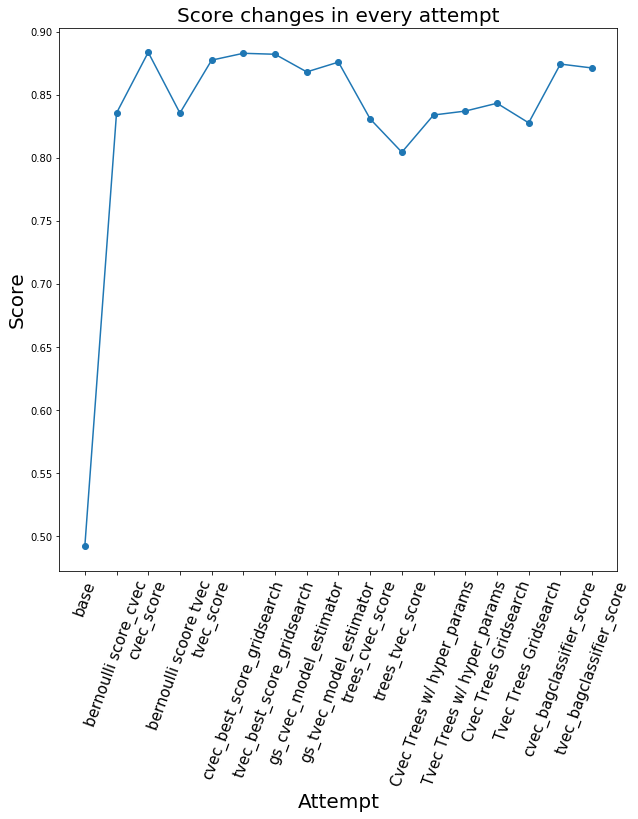

In [149]:
graphdf=pd.DataFrame({'x': range(0,17), 'y':  df['Test_Score']})
 
# plot
plt.figure(figsize=(10,10))
plt.plot( 'x', 'y', data=graphdf, linestyle='-', marker='o')
plt.title('Score changes in every attempt', fontsize=20)
plt.xlabel('Attempt', fontsize=20)
plt.xticks(range(17), Names, rotation=70, fontsize='15')
plt.ylabel('Score', fontsize=20)
plt.show()

### Only Cvec graph

In [150]:
Names2= ['base',
        'bernoulli score_cvec',
        'cvec_score', 
        'cvec_best_score_gridsearch',
        'gs_cvec_model_estimator',
        'trees_cvec_score', 
        'Cvec Trees w/ hyper_params',
        'Cvec Trees Gridsearch',
        'cvec_bagclassifier_score']

In [151]:
Test2 = [test_base,
        bernoulli_test_score_cvec,
        cvec_test_score, 
        grid_cvec_test_score, 
        gs_cvec_model_test_estimator, 
        trees_cvec_test,
        cvec_trees_test_params, 
        best_cvec_trees_model_test, 
        cvec_test_bagclassifier]

In [152]:
df2= pd.DataFrame(Test2)
df2.drop([0], axis=1, inplace=True)
df2['Classification Model']= Names2
df2['Test_Score']= Test2

df2

,Classification Model,Test_Score
0,base,0.491879
1,bernoulli score_cvec,0.835404
2,cvec_score,0.883540
3,cvec_best_score_gridsearch,0.882759
4,gs_cvec_model_estimator,0.868012
5,trees_cvec_score,0.830745
6,Cvec Trees w/ hyper_params,0.833851
7,Cvec Trees Gridsearch,0.843168
8,cvec_bagclassifier_score,0.874224


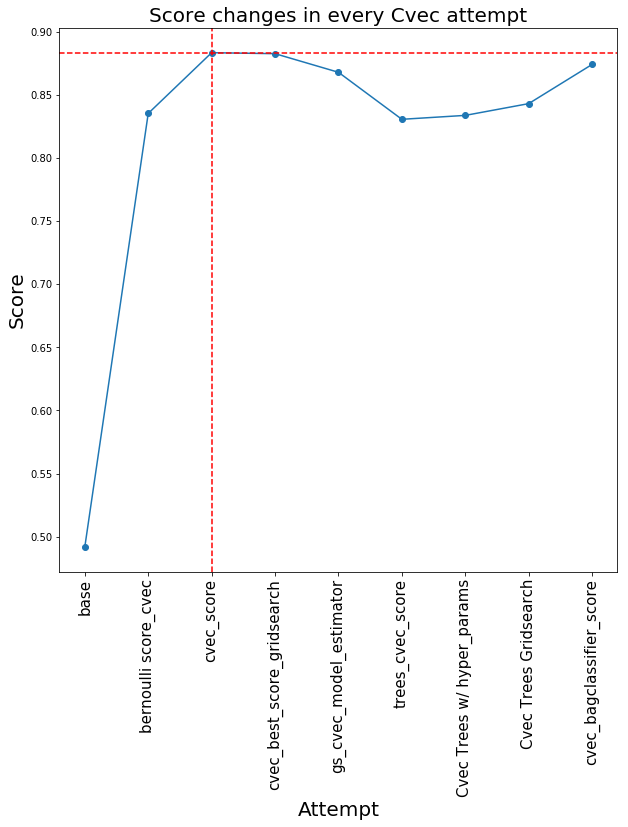

In [153]:
graphdf=pd.DataFrame({'x': range(0,9), 'y':  df2['Test_Score']})
 
# plot
plt.figure(figsize=(10,10))
plt.plot( 'x', 'y', data=graphdf, linestyle='-', marker='o')
plt.title('Score changes in every Cvec attempt', fontsize=20)
plt.xlabel('Attempt', fontsize=20)
plt.xticks(range(9), Names2, rotation=90, fontsize='15')
plt.ylabel('Score', fontsize=20)
xposition = [2]
for xc in xposition:
    plt.axvline(x=xc, color='r', linestyle='--')
plt.axhline(y=0.883540, color='r', linestyle='--')
plt.show()

### Only Cvec graph

In [154]:
Names3= ['base',
        'bernoulli scoore tvec', 
        'tvec_score',
        'tvec_best_score_gridsearch',
        'gs_tvec_model_estimator',
        'trees_tvec_score',
        'Tvec Trees w/ hyper_params',
        'Tvec Trees Gridsearch', 
        'tvec_bagclassifier_score']

In [155]:
Test3 = [test_base,
        bernoulli_test_score_tvec,
        tvec_test_score,
        grid_tvec_test_score,
        gs_tvec_model_test_estimator,
        trees_tvec_test, 
        tvec_trees_test_params, 
        best_tvec_trees_model_test, 
        tvec_test_bagclassifier] 

In [156]:
df3= pd.DataFrame(Test3)
df3.drop([0], axis=1, inplace=True)
df3['Classification Model']= Names3
df3['Test_Score']= Test3

df3

,Classification Model,Test_Score
0,base,0.491879
1,bernoulli scoore tvec,0.835404
2,tvec_score,0.877329
3,tvec_best_score_gridsearch,0.881992
4,gs_tvec_model_estimator,0.875776
5,trees_tvec_score,0.804348
6,Tvec Trees w/ hyper_params,0.836957
7,Tvec Trees Gridsearch,0.827640
8,tvec_bagclassifier_score,0.871118


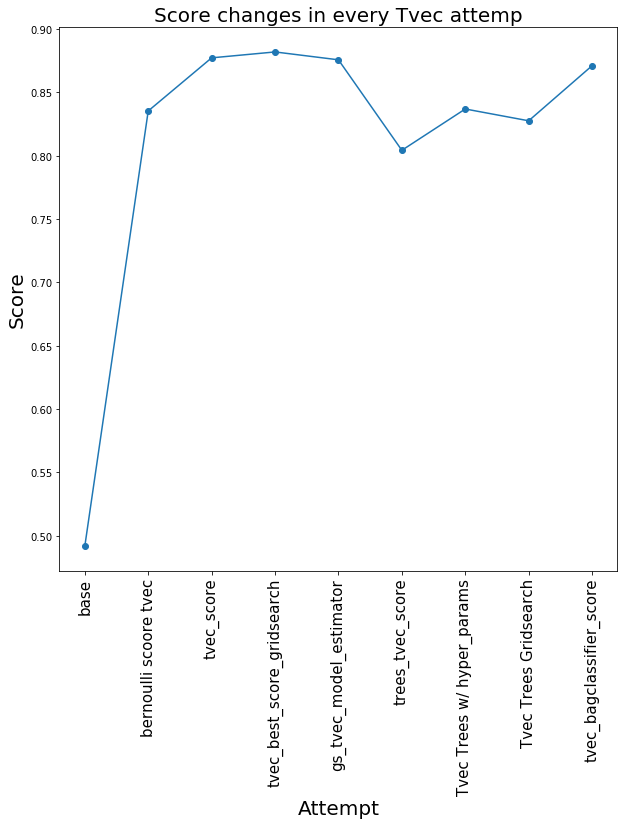

In [157]:
graphdf=pd.DataFrame({'x': range(0,9), 'y':  df3['Test_Score']})
 
# plot
plt.figure(figsize=(10,10))
plt.plot( 'x', 'y', data=graphdf, linestyle='-', marker='o')
plt.title('Score changes in every Tvec attemp', fontsize=20)
plt.xlabel('Attempt', fontsize=20)
plt.xticks(range(9), Names3, rotation=90, fontsize='15')
plt.ylabel('Score', fontsize=20)
plt.show()

# Conclusions:
**The evaluation of the findings obtained in this jupyter notebook will be discussed in the .readme as well as in the presentation. The study presented here serves to collect the data which will later be evaluated in relation to the pertaining questions of the project.**